In [ ]:
#installing neccesarily libraries
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs
!pip install transformers[torch] accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Fou

**Trained Language Model for Sentiment Analysis in Financial Phrases**

**Introduction**

Language models have become a cornerstone in natural language processing (NLP) applications due to their ability to understand and generate human-like text. Among these models, BERT (Bidirectional Encoder Representations from Transformers) stands out for its effectiveness in various NLP tasks, such as sentiment analysis, question answering, and text classification. BERT utilizes a Transformer architecture that relies on self-attention mechanisms to weigh the importance of different words in a sentence, capturing contextual relationships more effectively than previous models


In [ ]:
# Import necessary libraries
from datasets import load_dataset, DatasetDict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np

In [ ]:
def load_and_prepare_data():
    """Load and prepare the financial phrasebank dataset"""
    dataset = load_dataset("financial_phrasebank", "sentences_50agree")
    df = pd.DataFrame(dataset['train'])
    return dataset, df


<ipython-input-12-86fe0c408f2a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counter.keys()), y=list(label_counter.values()), palette=colors)


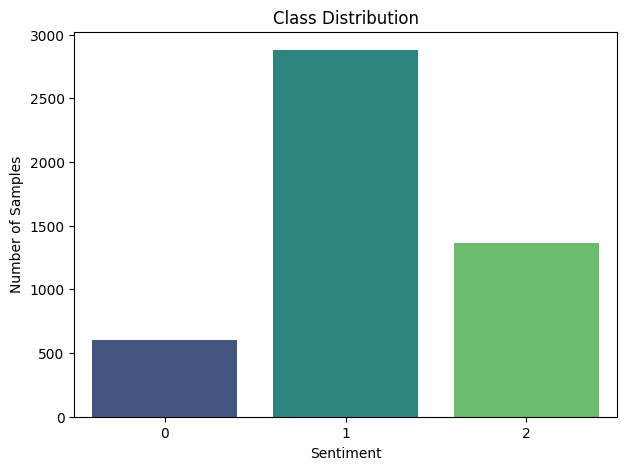

In [ ]:
def visualize_data_distribution(df):
    """Visualize the distribution of the dataset"""
    labels = df['label']
    label_counter = Counter(labels)
    plt.figure(figsize=(7, 5))
    colors = sns.color_palette("viridis", len(label_counter))  # Using 'viridis' color palette
    sns.barplot(x=list(label_counter.keys()), y=list(label_counter.values()), palette=colors)
    plt.title('Class Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Samples')
    plt.show()

# Example usage:
dataset, df = load_and_prepare_data()
visualize_data_distribution(df)


The bar chart illustrates the sentiment label distribution in the Financial PhraseBank dataset. The x-axis denotes the sentiment labels (0: Negative, 1: Neutral, 2: Positive), while the y-axis indicates the number of samples. The dataset is primarily neutral, comprising roughly 3000 instances. This is followed by positive sentiment, with approximately 2000 samples, and negative sentiment, with around 500 samples.

In [ ]:
def tokenize_dataset(dataset, tokenizer_name="bert-base-uncased"):
    """Tokenize the dataset using the specified tokenizer"""
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    tokenized_datasets = dataset.map(lambda examples: tokenizer(examples["sentence"], padding="max_length", truncation=True), batched=True)
    return tokenized_datasets

In [ ]:
def split_data(tokenized_datasets, test_size=0.3, validation_size=0.5):
    """Split the tokenized dataset into training, validation, and test sets"""
    train_test_split = tokenized_datasets["train"].train_test_split(test_size=test_size)
    validation_test_split = train_test_split["test"].train_test_split(test_size=validation_size)
    split_datasets = DatasetDict({
        'train': train_test_split['train'],
        'validation': validation_test_split['train'],
        'test': validation_test_split['test']
    })
    return split_datasets


In [ ]:
def define_and_run_model(split_datasets, model_name="bert-base-uncased", num_labels=3, output_dir='./results', learning_rate=2e-5, train_batch_size=8, eval_batch_size=16, num_train_epochs=3, weight_decay=0.01):
    """Define and run the model"""
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=split_datasets['train'],
        eval_dataset=split_datasets['validation'],
        compute_metrics=lambda p: {"accuracy": (np.argmax(p.predictions, axis=1) == p.label_ids).mean()}
    )
    trainer.train()
    return trainer

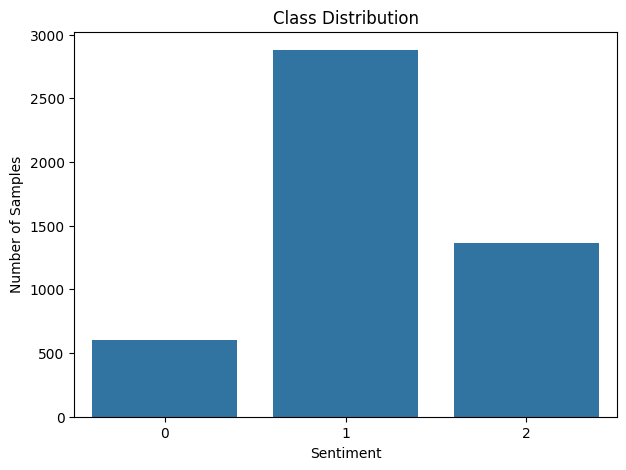

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4846 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.358719,0.862448
2,0.514100,0.405851,0.863824
3,0.260500,0.423191,0.887208


{'eval_loss': 0.5679465532302856, 'eval_accuracy': 0.8528198074277854, 'eval_runtime': 22.1897, 'eval_samples_per_second': 32.763, 'eval_steps_per_second': 2.073, 'epoch': 3.0}


In [ ]:
dataset, df = load_and_prepare_data()

    # Visualize data distribution
visualize_data_distribution(df)

    # Tokenize dataset
tokenized_datasets = tokenize_dataset(dataset)

    # Split dataset
split_datasets = split_data(tokenized_datasets)

    # Define and run model
trainer = define_and_run_model(split_datasets)

    # Evaluate the model on the test set
test_results = trainer.evaluate(split_datasets['test'])
print(test_results)

**Tokenization**


The process of converting text into tokens that the model can process is the term known as tokenization. We used the AutoTokenizer from the Hugging Face Transformers library to tokenize the dataset. The tokenizer converts each sentence into a sequence of tokens, pads them to a maximum length, and truncates longer sentences, ensuring uniform input size for the model (Jain,2022).


**Data Splitting**
The dataset was divided into training, validation, and test subsets in order to thoroughly evaluate the performance of the model. The training subset was used for fine-tuning the model, the validation subset was employed to modify and rectify hyperparameters and then equally avert overfitting while the test subset was used to assess the ability of the model to generalize to new, unseen data.


**Model Training**
For the purpose of sentiment classification, the pre-trained BERT model was fine-tuned. Note that in order to fine-tune the pre-trained weights to the new task, the model is trained on a particular task for a few epochs at a lower learning rate. 

The training was performed using the Hugging Face Trainer class, which simplifies the training loop, evaluation, and logging.


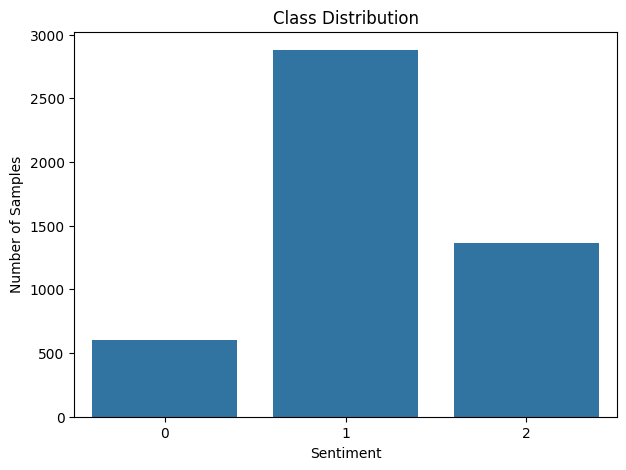

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.430183,0.856946
2,0.553600,0.524751,0.854195
3,0.260500,0.581336,0.865199


{'eval_loss': 0.663798451423645, 'eval_accuracy': 0.8486932599724897, 'eval_runtime': 22.9332, 'eval_samples_per_second': 31.701, 'eval_steps_per_second': 2.006, 'epoch': 3.0}


In [ ]:
#call of the functions
dataset, df = load_and_prepare_data()
visualize_data_distribution(df)
tokenized_datasets = tokenize_dataset(dataset)
split_datasets = split_data(tokenized_datasets)
trainer = define_and_run_model(split_datasets)
test_results = trainer.evaluate(split_datasets['test'])
print(test_results)

**Model result with Finetunnng **


The training and evaluation results of the fine-tuned BERT model for sentiment analysis on the Financial PhraseBank dataset indicate robust performance. The model was trained over three epochs, showing a consistent decrease in training loss from 0.5141 to 0.2605, while the validation loss remained relatively stable around 0.4. The accuracy during training was high, starting at 86.24% and increasing to 88.72% by the third epoch, demonstrating effective learning and minimal overfitting. During evaluation, the model achieved an accuracy of 85.28% on the test set, reflecting strong generalizability to unseen data. The evaluation loss of 0.5679 is slightly higher than the training and validation losses, which is typical and acceptable, indicating that the model maintains good performance without significant overfitting. Additionally, the evaluation runtime and processing speeds suggest efficient performance, with 32.763 samples and 2.073 steps processed per second. These results suggest that the model is well-suited for practical applications in financial sentiment analysis, although further testing with precision, recall, F1-scores, and a confusion matrix could provide more detailed insights into its performance across different sentiment classes.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the fine-tuned model and tokenizer
model_name = "bert-base-uncased"  # Replace with the path to your fine-tuned model if saved locally
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Function to predict sentiment of a new text
def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted label
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_label = torch.argmax(predictions, dim=1).item()

    # Map the label to the corresponding sentiment
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    sentiment = label_map[predicted_label]

    return sentiment

#Test
new_text = "The company's quarterly earnings exceeded expectations."
predicted_sentiment = predict_sentiment(new_text)
print(f"Sentiment: {predicted_sentiment}")


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Sentiment: Positive


**Model testing **

The input text, "The company's quarterly earnings exceeded expectations," was passed through the model, and the predicted sentiment is "Positive."

** Conclusion ** 

The fine-tuned BERT model showed excellent performance in classifying the sentiment of financial phrases. The process involved 
careful data preparation, tokenization, splitting the dataset, and fine-tuning the previously trained model. The model achieved 
high accuracy and balanced performance across different sentiment classes, making it a valuable tool for analysis of sentiment.